# Autoencoder for time series

## Notebook settings

In [1]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np

# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm = True, ratio_train = 0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]

In [3]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData('../data/UCRArchive_2018', 'ECG5000')

## Configuration hyperparameter

In [4]:
config = dict()  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64 # number of samples for iteration
config['learning_rate'] = .005 # for exponential decay
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 32 # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8 # Dropout rate

## Valuate sequence length

In [5]:
dataTrain.shape[0]
N = dataTrain.shape[0]
Nval = dataTest.shape[0]
D = dataTrain.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

3999

We have 3999 observations with 140 dimensions


## Valuate class number and min class

In [6]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 5 classes, 1.0 is the min class value


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(data, classes, plot_row=10, save = False, name = 'tmp', adjust=True):
    counts = dict(Counter(classes))
    uniqueClasses = np.unique(classes)
    num_classes = len(uniqueClasses)
    f, axarr = plt.subplots(plot_row, num_classes)
    for selectedClass in uniqueClasses:  # Loops over classes, plot as columns
        selectedClass = int(selectedClass)
        ind = np.where(classes == selectedClass)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, selectedClass].set_title('Class %.0f (%.0f elements)' % (selectedClass + 1, counts[float(selectedClass)]))
            if n < counts[float(selectedClass)]:
                axarr[n, selectedClass].plot(data[ind_plot[n], :])

                if not n == plot_row - 1:
                    plt.setp([axarr[n, selectedClass].get_xticklabels()], visible=False)
                if not selectedClass == 0:
                    plt.setp([axarr[n, selectedClass].get_yticklabels()], visible=False)
    
    if adjust == True:
        f.subplots_adjust(hspace=0)  # No horizontal space between subplots
        f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='png', dpi=1000)
        
    return


## Data class plot

Populating the interactive namespace from numpy and matplotlib


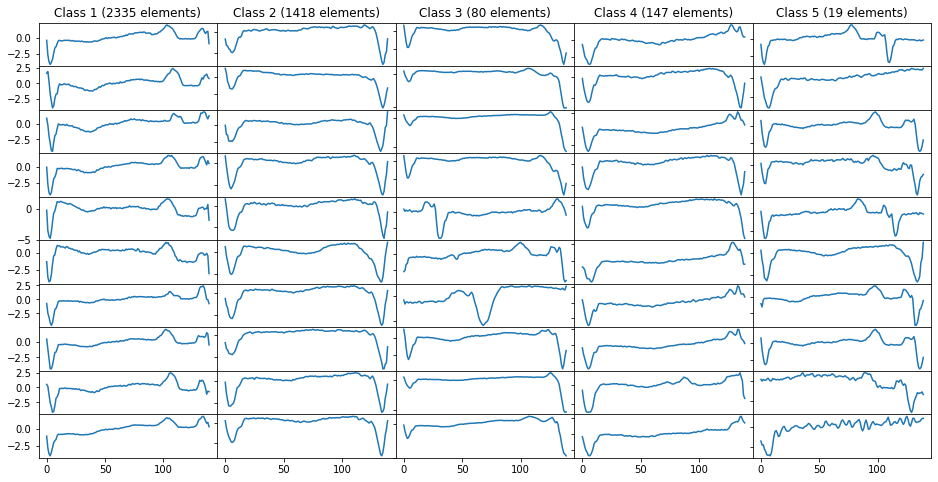

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain)
# plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

# Training time

## Net definition

In [9]:
import tensorflow as tf
from tensorflow.nn.rnn_cell import LSTMCell
import tensorflow_probability as tfp

class Model:
    def __init__(self, config):
        # Hyperparameters of the net
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        sl = config['sl']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.sl = sl
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, sl], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = tf.placeholder("float")

        with tf.variable_scope("Encoder"):
            # Th encoder cell, multi-layered with dropout
            cell_enc = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=self.keep_prob)

            # Initial state
            initial_state_enc = cell_enc.zero_state(batch_size, tf.float32)

            # with tf.name_scope("Enc_2_lat") as scope:
            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            outputs_enc, _ = tf.contrib.rnn.static_rnn(cell_enc,
                                                       inputs=tf.unstack(self.x_exp, axis=2),
                                                       initial_state=initial_state_enc)
            cell_output = outputs_enc[-1]
            b_mu = tf.get_variable('b_mu', [num_l])

            # self.z_mu is the Tensor containing the hidden representations
            # It can be used to do visualization, clustering or subsequent classification
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec"):
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        with tf.variable_scope("Decoder"):
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * sl
            # outputs_dec, _ = tf.nn.seq2seq.rnn_decoder(dec_inputs, initial_state_dec, cell_dec)
            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer"):
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [sl*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [sl, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tfp.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train"):
            # Use learning rte decay
            global_step = tf.Variable(0, trainable=False)
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients so that we can plot them on Tensorboard
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)
            #      for gradient, variable in gradients:  #plot the gradient of each trainable variable
            #        if isinstance(gradient, ops.IndexedSlices):
            #          grad_values = gradient.values
            #        else:
            #          grad_values = gradient
            #
            #        self.numel +=tf.reduce_sum(tf.size(variable))
            #        tf.summary.histogram(variable.name, variable)
            #        tf.summary.histogram(variable.name + "/gradients", grad_values)
            #        tf.summary.histogram(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))

            self.numel = tf.constant([[0]])
        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # and one op to initialize the variables
        self.init_op = tf.global_variables_initializer()

## Training model

In [10]:
import os

model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))

batch_size = config['batch_size']

# Start of the train
epochs = np.floor(batch_size * max_iterations / N)

print('Train with approximately %d epochs' % epochs)

sess.run(model.init_op)

step = 0  # Step is a counter for filling the numpy array perf_collect
for i in range(max_iterations):
    batch_ind = np.random.choice(N, batch_size, replace=False)
    result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                      feed_dict={model.x: dataTrain[batch_ind], model.keep_prob: dropout})
    
    if i % plot_every == 0:
        # Save train performances
        perf_collect[0, step] = loss_train = result[0]
        loss_train_seq, lost_train_lat = result[1], result[2]

        # Calculate and save validation performance
        batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                          feed_dict={model.x: dataTest[batch_ind_val], model.keep_prob: 1.0})
        perf_collect[1, step] = loss_val = result[0]
        loss_val_seq, lost_val_lat = result[1], result[2]
        # and save to Tensorboard
        summary_str = result[3]

        print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
        i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
        step += 1
    
saver = tf.train.Saver()
saver.save(sess, os.path.join("logs/ecg5000.ckpt"), step)

print("model trained, saved in logs directory")

W0715 11:01:48.540915  3184 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0715 11:01:48.541914  3184 deprecation.py:323] From <ipython-input-9-47a9c22f86e4>:26: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0715 11:01:48.544902  3184 deprecation.py:323] From <ipython-input-9-47a9c22f86e4>:26: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equiva

Train with approximately 16 epochs
At      0 /   1000 train (4.463, 2.015, 2.447), val (3.403, 1.870,1.533) in order (total, seq, lat)
At    100 /   1000 train (0.674, 0.668, 0.006), val (0.814, 0.813,0.001) in order (total, seq, lat)
At    200 /   1000 train (0.628, 0.621, 0.007), val (0.606, 0.601,0.005) in order (total, seq, lat)
At    300 /   1000 train (0.383, 0.376, 0.007), val (0.541, 0.537,0.004) in order (total, seq, lat)
At    400 /   1000 train (0.267, 0.261, 0.006), val (0.432, 0.431,0.001) in order (total, seq, lat)
At    500 /   1000 train (0.382, 0.375, 0.007), val (0.285, 0.280,0.005) in order (total, seq, lat)
At    600 /   1000 train (0.745, 0.710, 0.035), val (0.875, 0.865,0.010) in order (total, seq, lat)
At    700 /   1000 train (0.612, 0.600, 0.012), val (0.491, 0.486,0.005) in order (total, seq, lat)
At    800 /   1000 train (0.367, 0.361, 0.007), val (0.329, 0.325,0.004) in order (total, seq, lat)
At    900 /   1000 train (0.307, 0.301, 0.006), val (0.284, 0.278

'logs/ecg5000.ckpt-10'

model trained, saved in logs directory


## Get latent vector from model run on dataTest

In [11]:
saver = tf.train.Saver()
saver.restore(sess, save_path=os.path.join("logs/ecg5000.ckpt-10"))
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.extend(z_mu_fetch.tolist())
    start += batch_size

W0715 11:10:26.315231  3184 deprecation.py:323] From d:\workspaces\ideaprojects\progetto-data-science\venv\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## Plot test set on labels

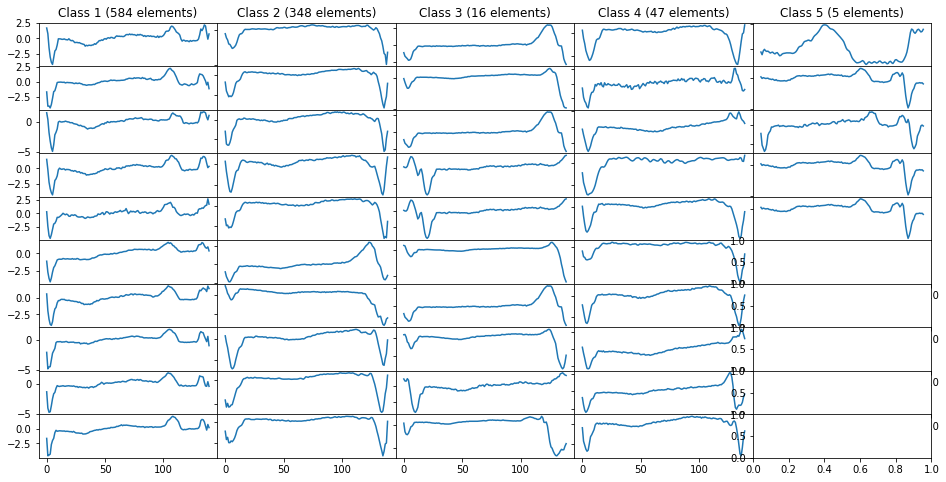

In [47]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(dataTest, labelsTest)

## Clustering based on latent vector of net

In [49]:
from sklearn.cluster import KMeans
from itertools import groupby

def getClustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    res = kmeans.fit_predict(features)
    kmeans.labels_ +=1
    res = res -1
    groups = groupby(sorted(zip(tuple(res), tuple(labelsTest))), lambda x: x[0])
    counts = {k: dict(Counter(x[1] for x in g)) for k, g in groups}
    return res, counts
res, counts = getClustering(z_run,3)
res

array([0, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 0, 1, 1, 1,
       2, 1, 1, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1,
       2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 0,
       2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2,
       1, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1,
       0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1,
       0, 2, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2,
       2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 2,
       2, 0, 0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 2, 0, 1, 2,
       1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 1, 1,
       1, 0, 2, 1, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1, 2,
       0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 2, 1, 2, 1, 0, 0, 1,
       2, 0, 1, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 1, 1,

## Plot test set on clustering results

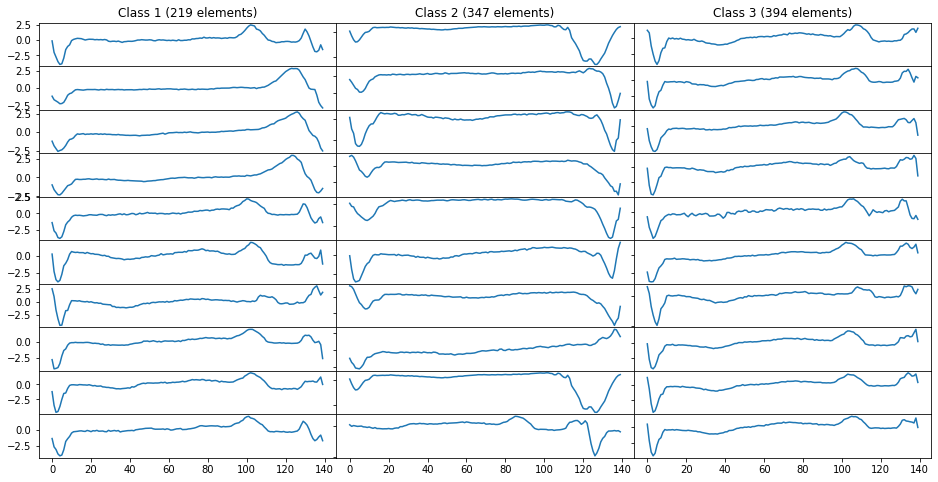

In [51]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(dataTest, res)

## Clustering Evaluation

In [52]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

ground_labels =[ int(lt) + 1 for lt in labelsTest[0:960] ]

cm = contingency_matrix(ground_labels, res)
ars = adjusted_rand_score(ground_labels, res)
nmis = normalized_mutual_info_score(ground_labels, res)
hs = homogeneity_score(ground_labels, res)
cs = completeness_score(ground_labels, res)
vm = v_measure_score(ground_labels, res)
fms = fowlkes_mallows_score(ground_labels, res)

print("Contingency Matrix")
print(cm)
print("Adjusted Rand Index: ", ars)
print("Normalized Mutual Information: ", nmis)
print("Homogeneity: ", hs)
print("Completeness: ", cs)
print("V-Measure: ", vm)
print("Fowlkes-Mallows score: ", fms)

Contingency Matrix
[[174   3 386]
 [ 32 294   4]
 [  6   9   1]
 [  5  39   2]
 [  2   2   1]]
Adjusted Rand Index:  0.5226864737626945
Normalized Mutual Information:  0.5168640980096966
Homogeneity:  0.5571557855957265
Completeness:  0.4794861737381666
V-Measure:  0.515411311313381
Fowlkes-Mallows score:  0.7203589134757309


d:\workspaces\ideaprojects\progetto-data-science\venv\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


## Visualize latent vector on PCA and tSNE

In [53]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

def plot_z_run(z_run, label, ):
    f1, ax1 = plt.subplots(2, 1)

    # First fit a PCA
    PCA_model = TruncatedSVD(n_components=3).fit(z_run)
    z_run_reduced = PCA_model.transform(z_run)
    ax1[0].scatter(z_run_reduced[:, 0], z_run_reduced[:, 1], c=label, marker='*', linewidths=0)
    ax1[0].set_title('PCA on z_run')

    # THen fit a tSNE
    tSNE_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000)
    z_run_tsne = tSNE_model.fit_transform(z_run)
    ax1[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=label, marker='*', linewidths=0)
    ax1[1].set_title('tSNE on z_run')

    plt.show()
    return

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 960 samples in 0.001s...
[t-SNE] Computed neighbors for 960 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 0.365468
[t-SNE] Computed conditional probabilities in 0.081s
[t-SNE] Iteration 50: error = 51.1687355, gradient norm = 0.2168013 (50 iterations in 0.568s)
[t-SNE] Iteration 100: error = 48.4193001, gradient norm = 0.1727114 (50 iterations in 0.521s)
[t-SNE] Iteration 150: error = 48.0663414, gradient norm = 0.1502213 (50 iterations in 0.485s)
[t-SNE] Iteration 200: error = 48.0106316, gradient norm = 0.1535299 (50 iterations in 0.492s)
[t-SNE] Iteration 250: error = 47.9286537, gradient norm = 0.1450510 (50 iterations in 0.501s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.928654
[t-SNE] Iteration 300: error = 0.2707156, gradient norm = 0.0004055 (50 iterations in 0.431s)
[t-SNE] Iteration 350: error = 0.2524849, gradient norm = 0.0001712 

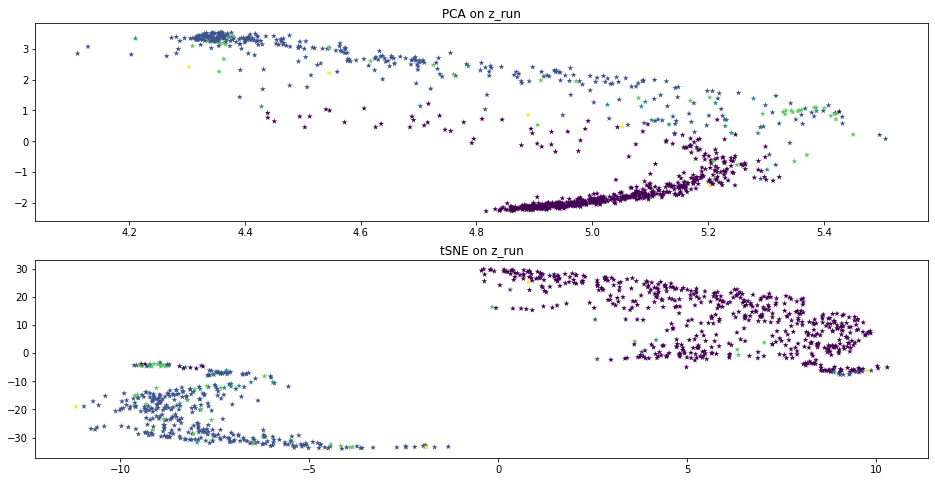

In [54]:
# Extract the latent space coordinates of the validation set
start = 0
label = []  # The label to save to visualize the latent space
z_run = []

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: dataTest[run_ind], model.keep_prob: 1.0})
    z_run.append(z_mu_fetch)
    start += batch_size

z_run = np.concatenate(z_run, axis=0)
label = labelsTest[:start]

plot_z_run(z_run, label)